# Simulations with regressions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
import sys
sys.path.append('./shapley_compute/')

## High number of independent features for linear regression

In [22]:
from shapley_compute.ensembled_mp import mp_shapley
from shapley_compute.minipatches import minipatch_regression_loo

In [23]:
def normal_linear_model(N, M, sigma2=0.4, s=0.2):
    """
    N: number of obs
    M: number of features
    sigma2: variance 
    s: sparsity level
    """ 
    np.random.seed(123)
    X = np.random.normal(0,1, size=(N,M))
    M1=int(s*M)
    beta = np.append(np.random.normal(5, 1, M1),np.array([0]*(M-M1))) # M-M1 beta are set to 0, M1 are non zeros
    eps = np.random.normal(0, sigma2, size=N)

    y = X@beta + eps
    return y, X, beta
    


In [24]:
N = 50000
M = 200
y, X, beta = normal_linear_model(N,M)

In [26]:
B = 10000
x_ratio = 0.2
model = LinearRegression()

In [ ]:
# fit a linear regression and evaluate shapley mp
res = minipatch_regression_loo(X, y, model, x_ratio, B)
pred, in_mp_obs, in_mp_loo, in_mp_feature = res
X_test = X[np.where(in_mp_loo == True)[1],:] 
shap_v = mp_shapley(X_test, res)

In [ ]:
all_features = np.unique(in_mp_feature,axis=0) # get all features sampled in MPs
print(all_features.shape[0], 2**20)

In [ ]:
plt.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0))

In [27]:
import shap
model = LinearRegression()
model.fit(X[~np.where(in_mp_loo == True)[1],:] ,y[~np.where(in_mp_loo == True)[1]] )
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values_lr = explainer(X_test)

ValueError: X has 20 features, but LinearRegression is expecting 200 features as input.

In [ ]:
plt.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0))

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (20,) and arg 3 with shape (200,).

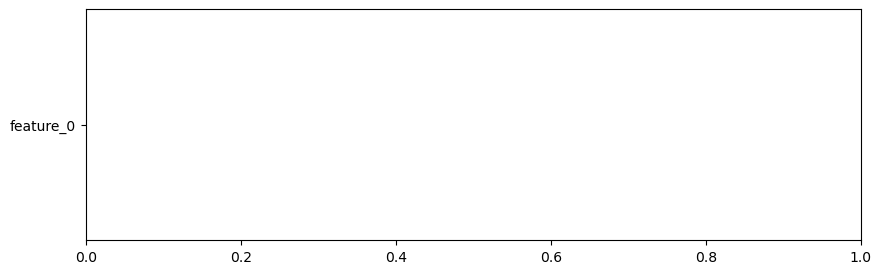

In [28]:
fig, ax = plt.subplots(figsize=(10,3))
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_v),axis=0), alpha=0.4, color='red')
ax.barh(['feature_{}'.format(i) for i in range(M)], np.mean(np.abs(shap_values_lr.values),axis=0), alpha = 0.4, color='blue')
ax.legend(['minipatch shapley', 'exact shapley'])
ax.set_title('Minipatch/exact shapley comparison for NLM with 3 independent non null effects and r={}, B={}'.format(x_ratio, B))
plt.savefig('./figures/NLM_shap_reg_2.svg')

In [29]:
import tqdm

In [40]:
x_ratio = [0.01, 0.05, 0.1]
B = [5000, 10000, 20000]
shap_dict = {}
for i in tqdm.tqdm(range(len(x_ratio))):
    res = minipatch_regression_loo(X, y, model, x_ratio[i], B[i])
    X_test = X[np.where(res[2] == True)[1],:] 
    shap_dict[i] = mp_shapley(X_test, res)

100%|██████████| 3/3 [27:26<00:00, 548.76s/it]


In [41]:
M = 200

In [44]:
X_test.shape

(20000, 200)

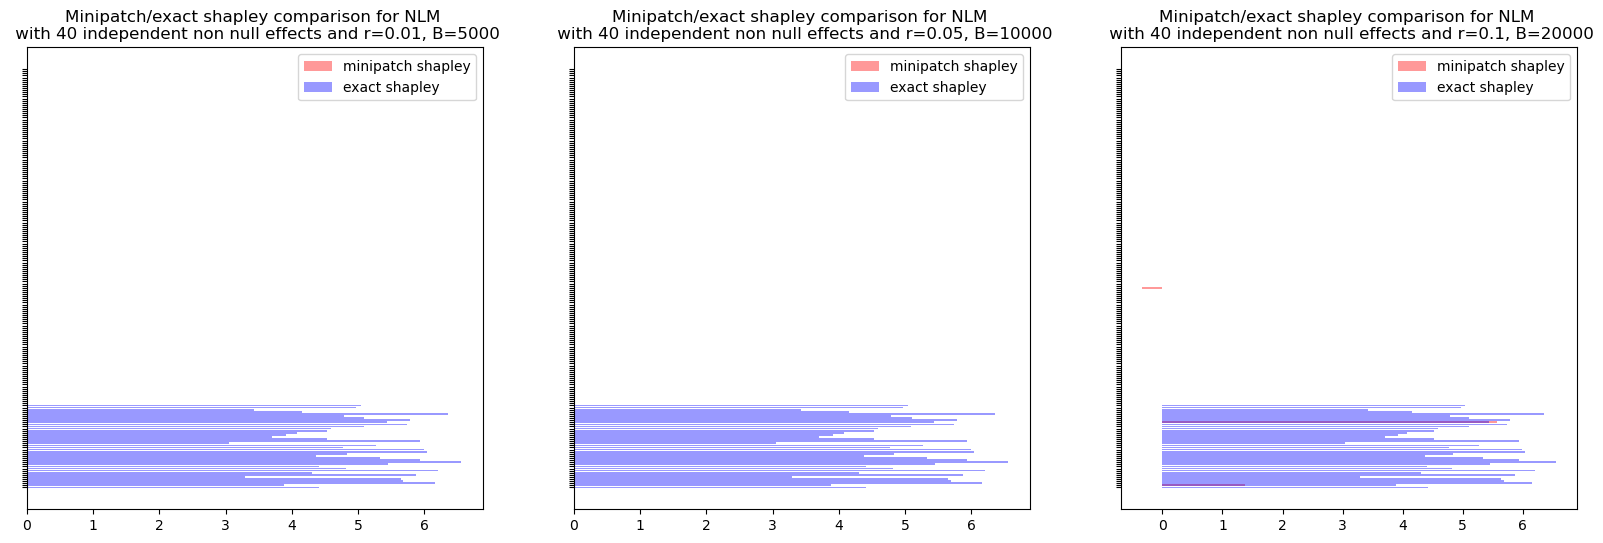

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))
for i in range(len(x_ratio)):
    ax[i].barh(['feature_{}'.format(i) for i in range(M)], np.mean(shap_dict[i],axis=0), alpha=0.4, color='red')
    ax[i].barh(['feature_{}'.format(i) for i in range(M)], beta, alpha = 0.4, color='blue')
    ax[i].legend(['minipatch shapley', 'exact shapley'])
    ax[i].set_title('Minipatch/exact shapley comparison for NLM \n with {} independent non null effects and r={}, B={}'.format(len(beta[~(beta ==0)]), x_ratio[i], B[i]))
    ax[i].yaxis.set_ticklabels([])
plt.savefig('./figures/NLM_shap_reg_2.svg')

40